Splice junctions are points on a DNA sequence at which `superfluous' DNA is removed during the process of protein creation in higher organisms. The problem posed in this dataset is to recognize, given a sequence of DNA, the boundaries between exons (the parts of the DNA sequence retained after splicing) and introns (the parts of the DNA sequence that are spliced out). This problem consists of two subtasks: recognizing exon/intron boundaries (referred to as EI sites), and recognizing intron/exon boundaries (IE sites). (In the biological community, IE borders are referred to a ``acceptors'' while EI borders are referred to as ``donors''.)

Attribute Information:

* 1. One of {n ei ie}, indicating the class.
* 2. The instance name.
* 3-62. The remaining 60 fields are the sequence, starting at position -30 and ending at position +30. Each of these fields is almost always filled by one of {a, g, t, c}. Other characters indicate ambiguity among the standard characters according to the following table:


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import time

In [2]:
# size of our kmer words
k_mer = 3
# dimesnion space of our embedding layer
EMB_DIM = 50

#### reading and exploring the data

In [3]:
splice_data = pd.read_csv('splice.data', header=None, names = ['class', 'donor', 'sequence'])
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [4]:
# we have 3 classes in this dataset
CLASS_NUM = 3

In [5]:
len(splice_data)

3190

In [6]:
splice_data['sequence'] = splice_data.apply(lambda x: str(x['sequence']), axis=1)
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [7]:
splice_data['class'].value_counts()

N     1655
IE     768
EI     767
Name: class, dtype: int64

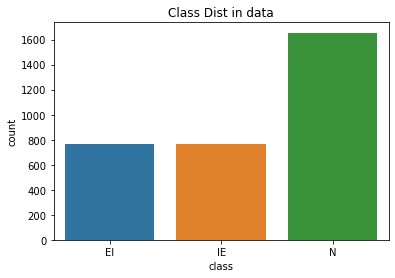

In [8]:
sns.countplot(x =splice_data['class'])
plt.title("Class Dist in data")
plt.show()

In [9]:
def kmer_fun(seq, win_size):
    kmer_list = []
    for x in range(len(seq) - win_size + 1):
        kmer_list.append(seq[x:x+win_size].lower())
    return kmer_list

#So let’s try it out with a simple sequence:
mySeq = 'CCAGCTG'
kmer_fun(mySeq, win_size= k_mer)

['cca', 'cag', 'agc', 'gct', 'ctg']

In [10]:
splice_data['sequence'] = splice_data.apply(lambda x : x['sequence'].strip(), axis = 1)
splice_data.head()

,class,donor,sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


In [11]:
splice_data[str(k_mer)+'-mer'] = splice_data.apply(lambda x : kmer_fun(x['sequence']
                                                    , win_size= k_mer), axis = 1)
splice_data.head()

,class,donor,sequence,3-mer
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,"[cca, cag, agc, gct, ctg, tgc, gca, cat, atc, ..."
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,"[aga, gac, acc, ccc, ccg, cgc, gcc, ccg, cgg, ..."
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,"[gag, agg, ggt, gtg, tga, gaa, aag, agg, gga, ..."
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,"[ggg, ggc, gct, ctg, tgc, gcg, cgt, gtt, ttg, ..."
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,"[gct, ctc, tca, cag, agc, gcc, ccc, ccc, ccc, ..."


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
splice_data['class'] = le.fit_transform(splice_data['class'])
splice_data.head()

,class,donor,sequence,3-mer
0,0,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,"[cca, cag, agc, gct, ctg, tgc, gca, cat, atc, ..."
1,0,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,"[aga, gac, acc, ccc, ccg, cgc, gcc, ccg, cgg, ..."
2,0,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,"[gag, agg, ggt, gtg, tga, gaa, aag, agg, gga, ..."
3,0,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,"[ggg, ggc, gct, ctg, tgc, gcg, cgt, gtt, ttg, ..."
4,0,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,"[gct, ctc, tca, cag, agc, gcc, ccc, ccc, ccc, ..."


In [13]:
# making sentences based on the k-mers
dna_texts = list(splice_data[str(k_mer)+'-mer'])
for item in range(len(dna_texts)):
    dna_texts[item] = ' '.join(dna_texts[item])

print('Sample 1: ', dna_texts[0])

Sample 1:  cca cag agc gct ctg tgc gca cat atc tca cac aca cag agg gga gag agg ggc gcc cca cag agc gcg cga gag agc gca cag agg ggt gtc tct ctg tgt gtt ttc tcc cca caa aag agg ggg ggc gcc cct ctt ttc tcg cga gag agc gcc cca cag agt gtc tct ctg


In [14]:
# get the labels
y = splice_data['class'].values 

In [15]:
# seperating the texts to train and test
X_train, X_test, y_train, y_test = train_test_split(dna_texts,
                                                    y,
                                                   random_state=42,
                                                   test_size=0.3,
                                                   stratify=y)


In [16]:
len(X_train), len(X_test)

(2233, 957)

In [17]:
# converting the labels to categorical one hot encoded format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [18]:
y_train.shape, y_test.shape

((2233, 3), (957, 3))

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
VOCAB_SIZE = len(word_index)

Found 88 unique tokens.


In [20]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
print('Sample 1 sequence: ',X_train_seq[0])
print()
X_train_padded = pad_sequences(X_train_seq, maxlen=len(X_train[0]))
print('Shape of train data tensor:', X_train_padded.shape)

Sample 1 sequence:  [18, 33, 39, 40, 36, 6, 7, 18, 33, 32, 61, 53, 13, 37, 35, 38, 21, 27, 19, 22, 23, 29, 39, 46, 12, 1, 24, 33, 3, 41, 45, 29, 3, 16, 9, 16, 37, 35, 3, 41, 17, 6, 13, 37, 35, 32, 31, 54, 62, 9, 5, 7, 30, 55, 56, 35, 3, 41]

Shape of train data tensor: (2233, 231)


In [21]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
print('Sample 1 sequence: ',X_test_seq[0])
print()
X_test_padded = pad_sequences(X_test_seq, maxlen= len(X_train[0]))
print('Shape of test data tensor:', X_test_padded.shape)

Sample 1 sequence:  [45, 12, 1, 24, 15, 11, 3, 16, 9, 27, 15, 4, 4, 2, 8, 29, 32, 31, 4, 2, 1, 20, 9, 16, 44, 34, 6, 7, 7, 30, 55, 49, 21, 5, 13, 9, 5, 7, 13, 9, 16, 44, 34, 6, 7, 7, 7, 30, 17, 28, 45, 29, 39, 34, 28, 45, 14, 4]

Shape of test data tensor: (957, 231)


### Helper funtions

In [25]:
# the funciton will draw a heat map
def eval_NN_model(model, X_test, y_test, title= 'Heat map'):
    predictions = model.predict(X_test)
    preds_int = np.argmax(predictions, axis = 1)
    y_test_int = np.argmax(y_test, axis = 1)
    cm = confusion_matrix(y_test_int, preds_int)
    plot_confusion_matrix(cm, figsize=(4,4), hide_ticks=True ,cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(range(CLASS_NUM), [str(i) for i in range(CLASS_NUM)], fontsize=12)
    plt.yticks(range(CLASS_NUM), [str(i) for i in range(CLASS_NUM)], fontsize=12)
    plt.show()
    
    f1_test = f1_score(y_test_int, preds_int, average = 'macro')
    print('test F1 score: {:.3f}'.format(f1_test))

### Models

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D
from tensorflow.keras.layers import MaxPool1D, Flatten, Dropout

In [27]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                      patience= 5, restore_best_weights= True)


#### ANN

In [30]:
chkpt1 = tf.keras.callbacks.ModelCheckpoint(
    'ANN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [31]:
model_ANN = Sequential()
model_ANN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_ANN.add(Flatten())
model_ANN.add(Dense(12, activation='relu'))
model_ANN.add(Dense(8, activation='relu'))
model_ANN.add(Dense(3, activation='softmax'))

model_ANN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ANN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 231, 50)           4450      
_________________________________________________________________
flatten (Flatten)            (None, 11550)             0         
_________________________________________________________________
dense (Dense)                (None, 12)                138612    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 143,193
Trainable params: 143,193
Non-trainable params: 0
_________________________________________________________________


In [32]:
import time
import numpy as np

eps = 100
start = time.time()
history1 = model_ANN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt1])

end = time.time()
print('Took {:.3f} seconds to train'.format(end-start))

C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
70/70 [==============================] - 3s 23ms/step - loss: 1.0062 - accuracy: 0.5168 - val_loss: 0.9422 - val_accuracy: 0.5193
Epoch 2/100
70/70 [==============================] - 2s 22ms/step - loss: 0.7175 - accuracy: 0.6610 - val_loss: 0.5777 - val_accuracy: 0.7868
Epoch 3/100
70/70 [==============================] - 2s 22ms/step - loss: 0.4298 - accuracy: 0.9145 - val_loss: 0.3489 - val_accuracy: 0.9206
Epoch 4/100
70/70 [==============================] - 2s 22ms/step - loss: 0.2826 - accuracy: 0.9570 - val_loss: 0.2405 - val_accuracy: 0.9676
Epoch 5/100
70/70 [==============================] - 2s 23ms/step - loss: 0.1112 - accuracy: 0.9767 - val_loss: 0.1893 - val_accuracy: 0.9321
Epoch 6/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0613 - accuracy: 0.9839 - val_loss: 0.1116 - val_accuracy: 0.9687
Epoch 7/100
70/70 [==============================] - 2s 23ms/step - loss: 0.0360 - accuracy: 0.9933 - val_loss: 0.1175 - val_accuracy: 0.9645
Epoch 

In [33]:
model_ANN.load_weights('weights/ANN_weights')

C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


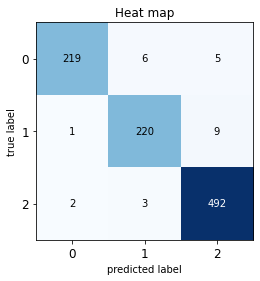

test F1 score: 0.970


In [34]:
eval_NN_model(model_ANN, X_test_padded, y_test)

#### RNN

In [41]:
chkpt2 = tf.keras.callbacks.ModelCheckpoint(
    'weights/RNN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [57]:
LSTM_UNITS = 50

model_RNN = Sequential()
model_RNN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_RNN.add(LSTM(units = LSTM_UNITS, return_sequences = True))
model_RNN.add(LSTM(units = LSTM_UNITS))
model_RNN.add(Dense(CLASS_NUM, activation = 'softmax'))

model_RNN.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', metrics = ['accuracy'])
model_RNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 231, 50)           4450      
_________________________________________________________________
lstm_4 (LSTM)                (None, 231, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 153       
Total params: 45,003
Trainable params: 45,003
Non-trainable params: 0
_________________________________________________________________


In [58]:
start = time.time()
history2 = model_RNN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt2])
end = time.time()
print('Took {:.3f} seconds to train'.format(end-start))

C:\Users\moein\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
70/70 [==============================] - 3s 46ms/step - loss: 1.0040 - accuracy: 0.5293 - val_loss: 0.9389 - val_accuracy: 0.5528
Epoch 2/100
70/70 [==============================] - 3s 43ms/step - loss: 0.7797 - accuracy: 0.6386 - val_loss: 0.6453 - val_accuracy: 0.6938
Epoch 3/100
70/70 [==============================] - 3s 42ms/step - loss: 0.5922 - accuracy: 0.7335 - val_loss: 0.4875 - val_accuracy: 0.7983
Epoch 4/100
70/70 [==============================] - 3s 42ms/step - loss: 0.4613 - accuracy: 0.8168 - val_loss: 0.4660 - val_accuracy: 0.7962
Epoch 5/100
70/70 [==============================] - 3s 43ms/step - loss: 0.3891 - accuracy: 0.8540 - val_loss: 0.4406 - val_accuracy: 0.8422
Epoch 6/100
70/70 [==============================] - 3s 42ms/step - loss: 0.3759 - accuracy: 0.8607 - val_loss: 0.3694 - val_accuracy: 0.8610
Epoch 7/100
70/70 [==============================] - 3s 43ms/step - loss: 0.3050 - accuracy: 0.8867 - val_loss: 0.3386 - val_accuracy: 0.8736
Epoch 

In [59]:
model_RNN.load_weights('weights/RNN_weights')

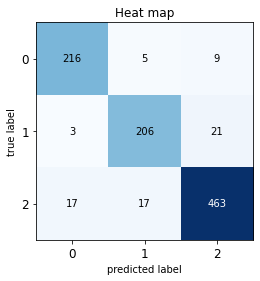

test F1 score: 0.921


In [60]:
eval_NN_model(model_RNN, X_test_padded, y_test)

#### CNN

In [49]:
chkpt3 = tf.keras.callbacks.ModelCheckpoint(
    'weights/CNN_weights', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True
)

In [52]:
model_CNN = Sequential()
model_CNN.add(Embedding(VOCAB_SIZE+1, EMB_DIM, input_length = X_train_padded.shape[1]))
model_CNN.add(Conv1D(filters = 100, kernel_size = 3, activation='relu'))
model_CNN.add(MaxPool1D(pool_size = 2, strides=2))
model_CNN.add(Flatten())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(CLASS_NUM, activation= 'softmax'))

model_CNN.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', metrics = ['accuracy'])
model_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 231, 50)           4450      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 229, 100)          15100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 100)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11400)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11400)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 34203     
Total params: 53,753
Trainable params: 53,753
Non-trainable params: 0
__________________________________________________

In [53]:
start = time.time()
history3 = model_CNN.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test),
          epochs = eps, batch_size = 32, shuffle = True, callbacks = [es, chkpt3])
end = time.time()
print('Took {:.3f} seconds to train'.format(end-start, eps))

Epoch 1/100
70/70 [==============================] - 2s 28ms/step - loss: 0.9017 - accuracy: 0.5858 - val_loss: 0.5266 - val_accuracy: 0.9070
Epoch 2/100
70/70 [==============================] - 2s 26ms/step - loss: 0.2463 - accuracy: 0.9346 - val_loss: 0.1392 - val_accuracy: 0.9592
Epoch 3/100
70/70 [==============================] - 2s 26ms/step - loss: 0.1249 - accuracy: 0.9655 - val_loss: 0.1250 - val_accuracy: 0.9530
Epoch 4/100
70/70 [==============================] - 2s 26ms/step - loss: 0.1048 - accuracy: 0.9700 - val_loss: 0.1299 - val_accuracy: 0.9613
Epoch 5/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0860 - accuracy: 0.9740 - val_loss: 0.1124 - val_accuracy: 0.9634
Epoch 6/100
70/70 [==============================] - 2s 26ms/step - loss: 0.0756 - accuracy: 0.9758 - val_loss: 0.1114 - val_accuracy: 0.9624
Epoch 7/100
70/70 [==============================] - 2s 25ms/step - loss: 0.0651 - accuracy: 0.9803 - val_loss: 0.1117 - val_accuracy: 0.9707
Epoch 

In [54]:
model_CNN.load_weights('weights/CNN_weights')

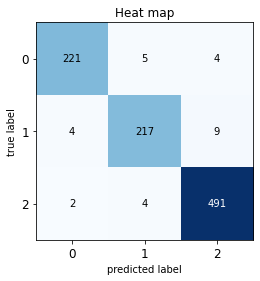

test F1 score: 0.967


In [55]:
eval_NN_model(model_CNN, X_test_padded, y_test)